<a href="https://colab.research.google.com/github/Vedant-Mahadik/DesignOptimizationFall2022/blob/main/Project01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)


In [45]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 9.81  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant
ROT_ACCEL = 0.10  # angular acceleration
DRAG_ACCEL = 0.05  # acceleration due to drag



# # the following parameters are not being used in the sample code
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height
# ROTATION_ACCEL = 20  # rotation constant

In [57]:
# define system dynamics
# Notes:
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):
        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        state[2] = theta
        state[3] = theta_dot
        """

        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is
        # part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx.
        # This is allowed...
        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME, 0., 0.])


        # Thrust
        # Note: Same reason as above. Need a 2-by-1 tensor.
        # Note: Action provided by controller to determine thrust or no thrust.
        delta_state = BOOST_ACCEL * FRAME_TIME * t.tensor([0., 1, 0., 0.]) * action[0]

        temp = delta_state

        #Updating drag
        DRAG_DECEL = 0.00658 * temp* temp
        
        NET_ACCEL = BOOST_ACCEL - DRAG_DECEL

        #Re-calculating new velocity
        delta_state = NET_ACCEL * FRAME_TIME * t.tensor([0., -1., 0., 0.]) * action[0]

        

        # Drag
        # Acts in opposite direction of velocity
        delta_state_drag = DRAG_ACCEL * FRAME_TIME * t.tensor([0., -1., 0., 0.])



        # Rotational thrust
        delta_state_rot = ROT_ACCEL * FRAME_TIME * t.tensor([0., 0., 0., 1.]) * action[1]

        # Update velocity
        state = state + delta_state + delta_state_gravity + delta_state_drag + delta_state_rot

        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible.
        # Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., FRAME_TIME, 0., 0.],
                            [0., 1., 0., 0.],
                            [0., 0., 1., FRAME_TIME],
                            [0., 0., 0., 1.]])
        state = t.matmul(step_mat, state)

        return state

In [53]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or
# deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Tanh()
        )

    # Forward updates action, which is passed to dynamics as control for next step
    def forward(self, state):
        action = (self.network(state))
        return action

In [54]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of
# initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state
# trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [1., 0., -0.5, 0.]  # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()  # TODO: Why does requires_grad=False?

    def error(self, state):
        return state[0]**2 + state[1]**2 + state[2]**2 + state[3]**2

In [55]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider
# simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)
        self.loss = []

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()  # TODO: Why is this necessary?
            loss.backward()
            return loss

        self.optimizer.step(closure)  # TODO: Does this pass the gradient of loss to the optimizer, which performs GD?
        return closure()

    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.loss.append(loss.detach().numpy())
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        actions = np.array([self.simulation.action_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        fig, axs = plt.subplots(2)
        x1 = data[:, 0]
        y1 = data[:, 1]
        x2 = data[:, 2]
        y2 = data[:, 3]
        axs[0].plot(x1, y1)
        axs[0].grid()
        axs[0].set_xlabel('Distance to Landing')
        axs[0].set_ylabel('Vertical Velocity')
        axs[1].plot(x2, y2)
        axs[1].grid()
        axs[1].set_xlabel('Orientation')
        axs[1].set_ylabel('Angular Velocity')
        plt.show()

[1] loss: 3.853


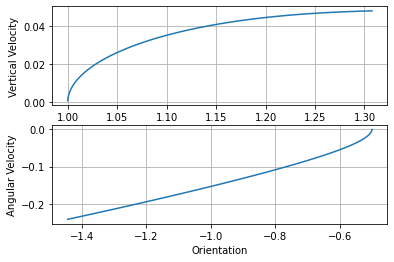

[2] loss: 1.765


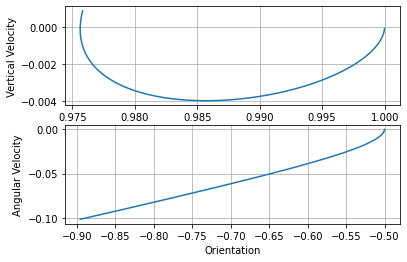

[3] loss: 0.960


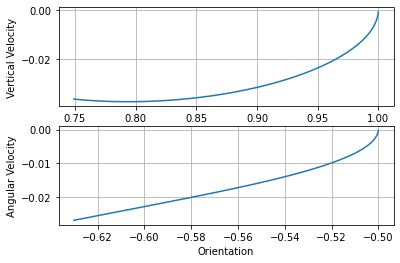

[4] loss: 0.569


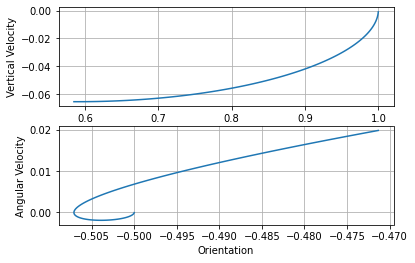

[5] loss: 0.359


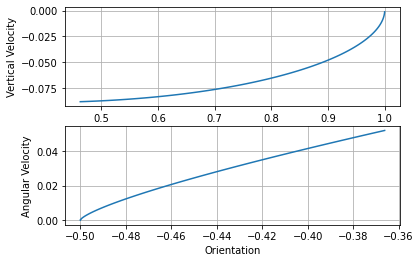

[6] loss: 0.239


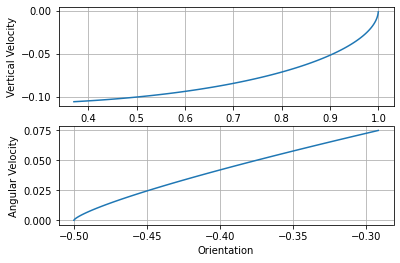

[7] loss: 0.168


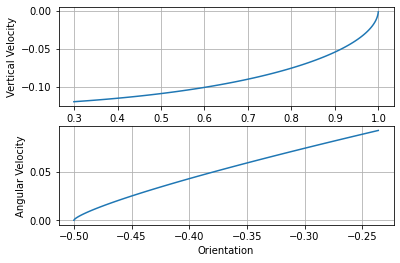

[8] loss: 0.124


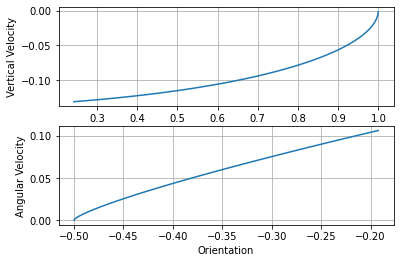

[9] loss: 0.097


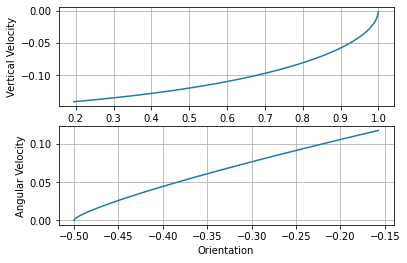

[10] loss: 0.081


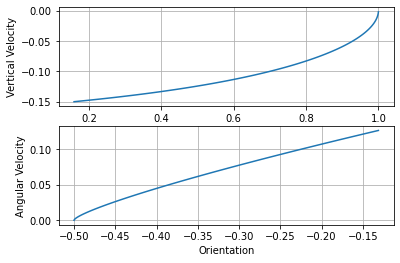

[11] loss: 0.072


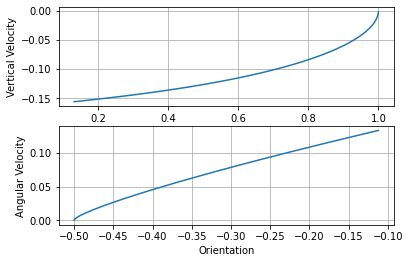

[12] loss: 0.067


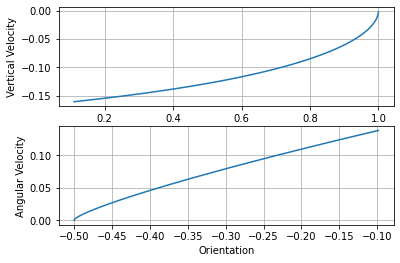

[13] loss: 0.064


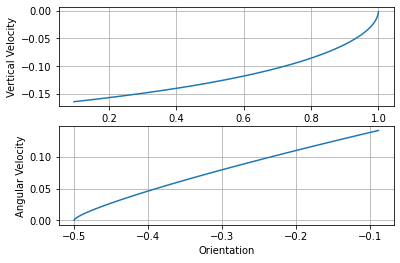

[14] loss: 0.062


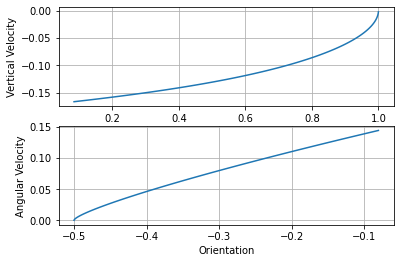

[15] loss: 0.061


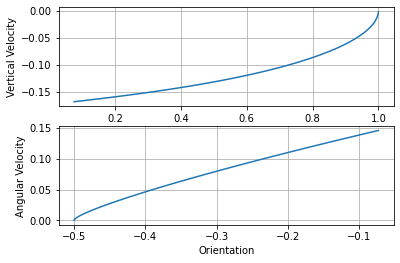

[16] loss: 0.057


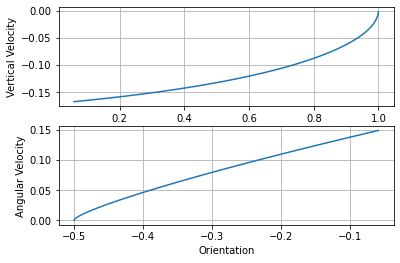

[17] loss: 0.054


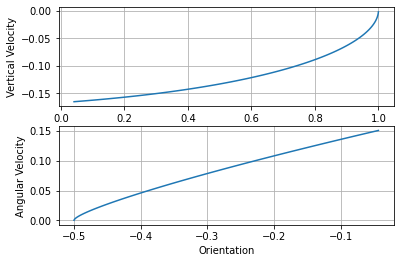

[18] loss: 0.052


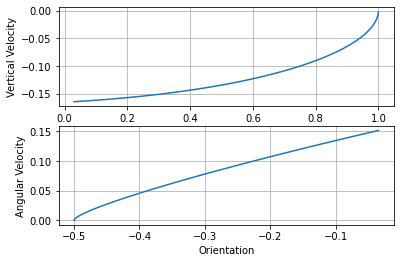

[19] loss: 0.051


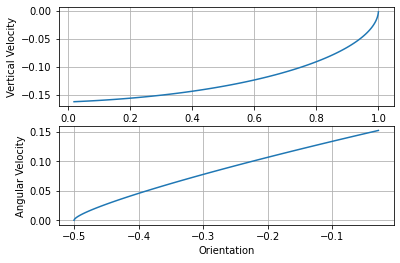

[20] loss: 0.046


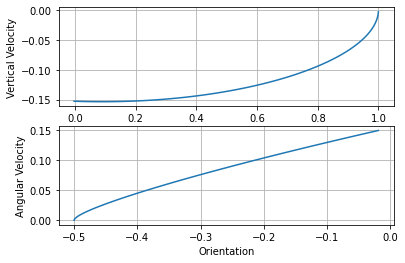

[21] loss: 0.017


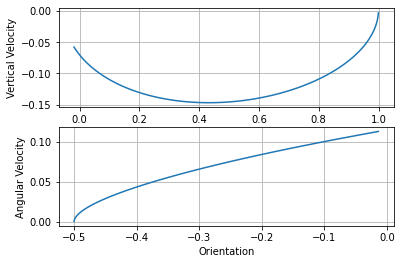

[22] loss: 0.013


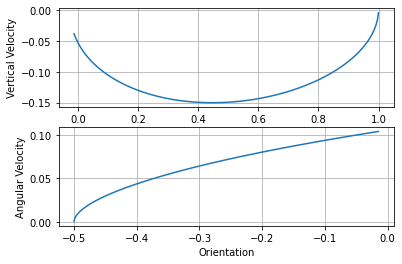

[23] loss: 0.010


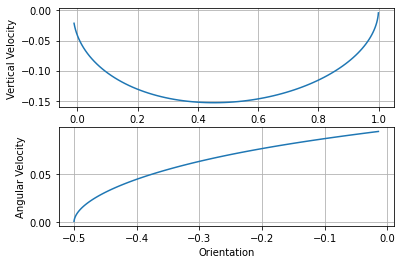

[24] loss: 0.007


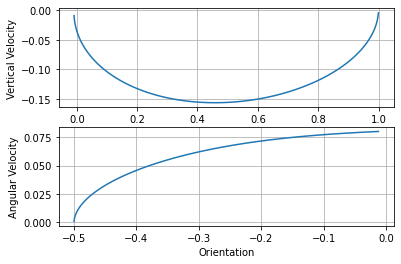

[25] loss: 0.004


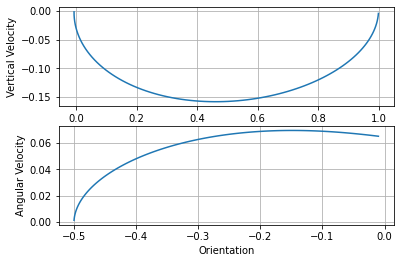

[26] loss: 0.003


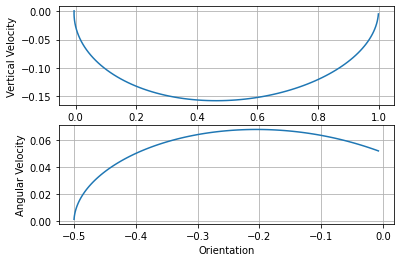

[27] loss: 0.002


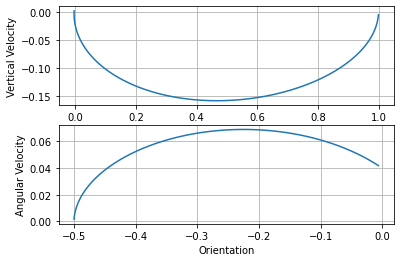

[28] loss: 0.001


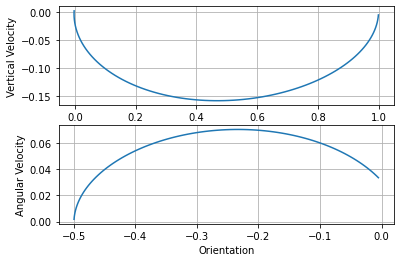

[29] loss: 0.001


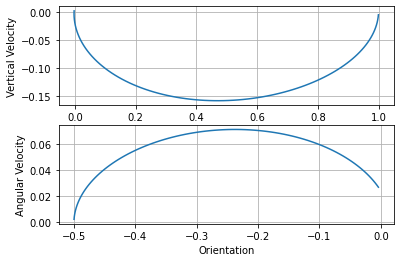

[30] loss: 0.000


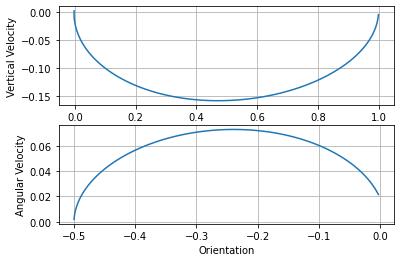

[31] loss: 0.000


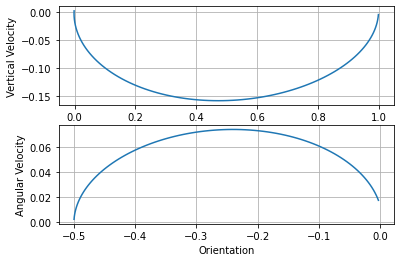

[32] loss: 0.000


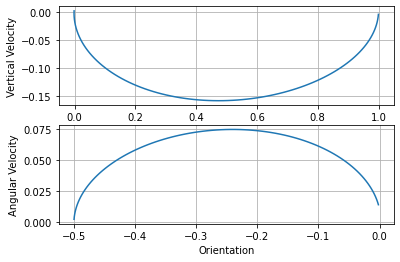

[33] loss: 0.000


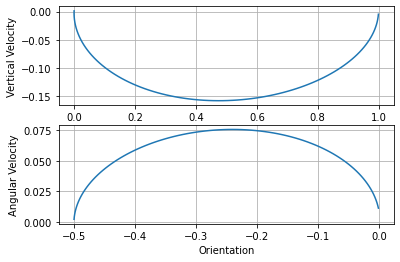

[34] loss: 0.000


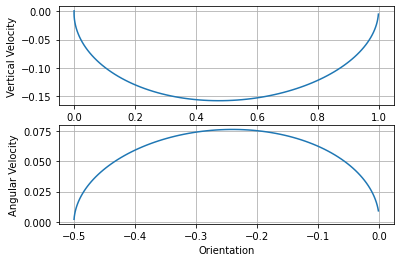

[35] loss: 0.000


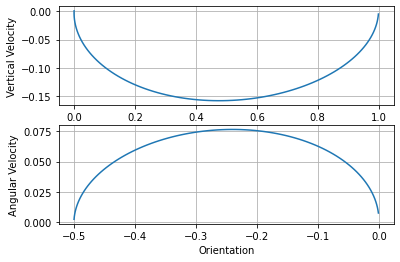

[36] loss: 0.000


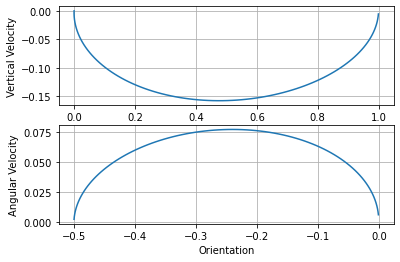

[37] loss: 0.000


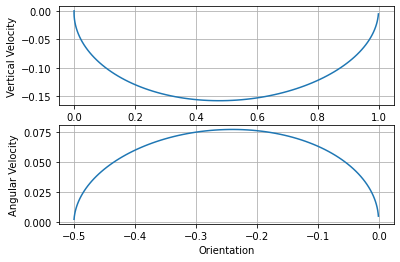

[38] loss: 0.000


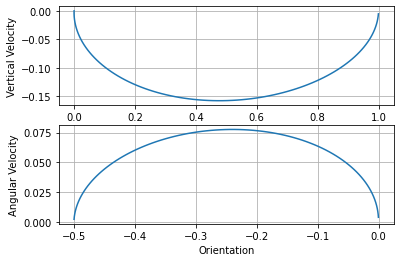

[39] loss: 0.000


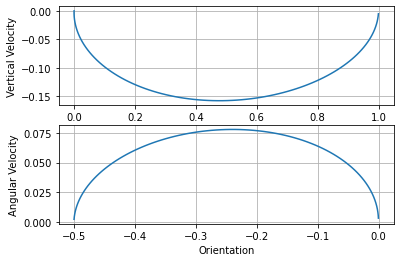

[40] loss: 0.000


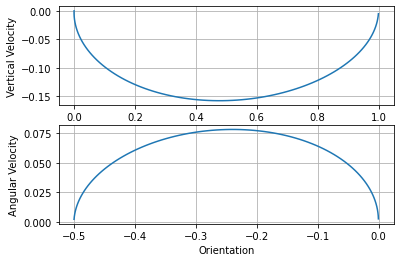

In [58]:
# Now it's time to run the code!

store_loss = []
T = 100  # number of time steps
dim_input = 4  # state space dimensions
dim_hidden = 16  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(40)  # solve the optimization problem
store_loss.append(o.loss)
